<a href="https://colab.research.google.com/github/wanyuL/ReinforcementRats2021/blob/master/RNN_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run rnn0 on fake data

In [25]:
%load_ext autoreload
%autoreload 2

# Colab:
# ! git clone https://github.com/wanyuL/ReinforcementRats2021.git 
# import sys 
# sys.path.append('./ReinforcementRats2021')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import nmastandard as nmas
import rnnautoencoder as rnnae
from rnn0 import *
from gen_fake_data import *
from load_data import *
import pickle
from torch import nn

In [27]:
device=nmas.set_device()  # select device


In [28]:
# prepare for training

# file = open("Cori_MOs.pkl",'rb')
file = open("Cori_Post.pkl",'rb')
spk = pickle.load(file)

NT=spk.shape[0]
ntrials=spk.shape[1]
NN=spk.shape[2]
ncomp=10

# gen_save_indices(spk, ntrials)

trainidx, validx, testidx = pull_indices()
trainDat = spk[:, trainidx, :].copy()
valDat = spk[:, validx, :].copy()
testDat = spk[:, testidx, :].copy()

trainingData = torch.from_numpy(trainDat).to(device).float()
valData = torch.from_numpy(valDat).to(device).float()
testData = torch.from_numpy(testDat).to(device).float()


In [12]:
#NN1 = trainingData.shape[-1]
#NN2 = valData.shape[-1]

# we initialize the neural network
# net = rnn0(ncomp, trainingData.shape[-1], trainingData.shape[-1], dropout=0.5 ,bidi = False).to(device)
# net = rnnae.RNNAE(trainingData.shape[-1], 50, [100, 75], [75, 100])

# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
# net.fc.bias.data[:] = trainingData.mean((0,1))


In [30]:
trainingData.shape

torch.Size([250, 150, 254])

Naive 0 Guess Accuracy: 0.9656201601028442
Random seed 2021 has been set.


MSE Train @ 0: Loss — 0.14004096388816833, Acc — 0.5643686056137085
	Val @ 0: Loss — 0.1403570920228958, Acc — 0.5643140077590942

Random seed 2021 has been set.


MSE Train @ 0: Loss — 0.08490493893623352, Acc — 0.5971562266349792
	Val @ 0: Loss — 0.08602657169103622, Acc — 0.5963552594184875

Random seed 2021 has been set.


MSE Train @ 0: Loss — 0.05192742124199867, Acc — 0.6501204371452332
	Val @ 0: Loss — 0.053402189165353775, Acc — 0.6490330696105957

Random seed 2021 has been set.


MSE Train @ 0: Loss — 0.04264124855399132, Acc — 0.7666059732437134
	Val @ 0: Loss — 0.044113121926784515, Acc — 0.7657146453857422

Random seed 2021 has been set.


MSE Train @ 0: Loss — 0.04120622202754021, Acc — 0.8146411776542664
	Val @ 0: Loss — 0.042726024985313416, Acc — 0.8135924339294434



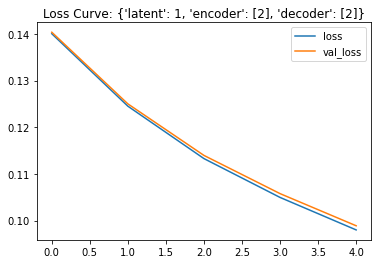

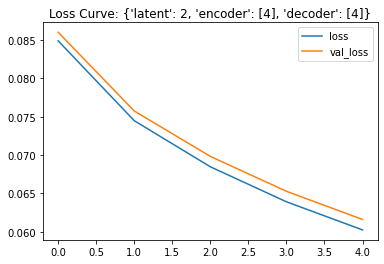

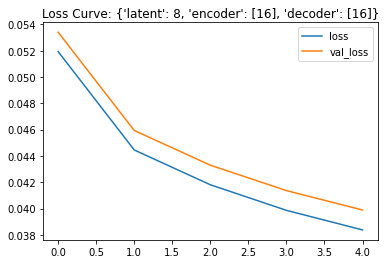

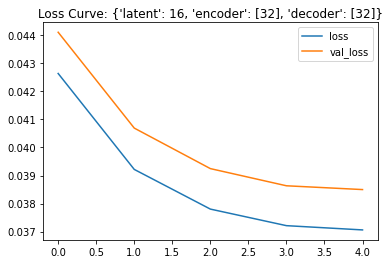

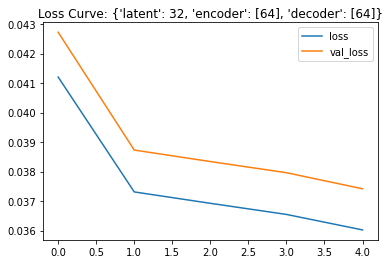

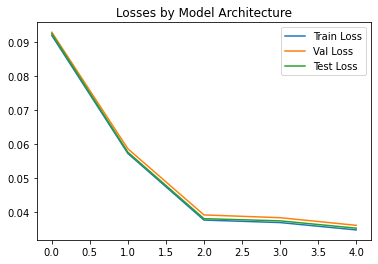

In [55]:
# train the rnn!

print(f'Naive 0 Guess Accuracy: {1-(valData > 0).float().mean()}')

model_spec_lst = [
    {'latent': 1, 'encoder':[2], 'decoder':[2]},
    {'latent': 2, 'encoder':[4], 'decoder':[4]},
    {'latent': 8, 'encoder':[16], 'decoder':[16]},
    {'latent': 16, 'encoder':[32], 'decoder':[32]},
    {'latent': 32, 'encoder':[64], 'decoder':[64]},
]

train_loss_lst = []
val_loss_lst = []
test_loss_lst = []

for model_spec in model_spec_lst:
    SEED = 2021
    nmas.set_seed(seed=SEED)
    DEVICE = nmas.set_device()

    latent = model_spec['latent']
    encoder = model_spec['encoder']
    decoder = model_spec['decoder']

    net = rnnae.RNNAE(trainingData.shape[-1], latent, encoder, decoder)
    loss, val_loss = rnnae.train_autoencoder(net, trainingData, DEVICE, val_dataset=valData, epochs=5, batch_size=20, seed=0)

    tr_pred = net.forward(trainingData)
    fin_tr_loss = nn.MSELoss()(tr_pred.cpu(), trainingData.cpu())
    val_pred = net.forward(valData)
    fin_val_loss = nn.MSELoss()(val_pred.cpu(), valData.cpu())
    test_pred = net.forward(testData)
    fin_test_loss = nn.MSELoss()(test_pred.cpu(), testData.cpu())


    # might not expect the model to generalize well, as the adjacency matrices might 
    # differ between different neuron subpopulations

    plt.figure()
    plt.title(f'Loss Curve: {model_spec}')
    plt.plot(loss, label='loss')
    plt.plot(val_loss, label='val_loss')
    plt.legend()

    train_loss_lst.append(fin_tr_loss.cpu().item())
    val_loss_lst.append(fin_val_loss.cpu().item())
    test_loss_lst.append(fin_test_loss.cpu().item())

plt.figure()
plt.title('Losses by Model Architecture')
plt.plot(train_loss_lst, label='Train Loss')
plt.plot(val_loss_lst, label='Val Loss')
plt.plot(test_loss_lst, label='Test Loss')
plt.legend()


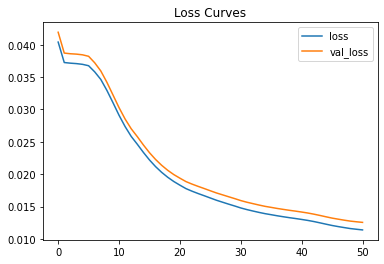

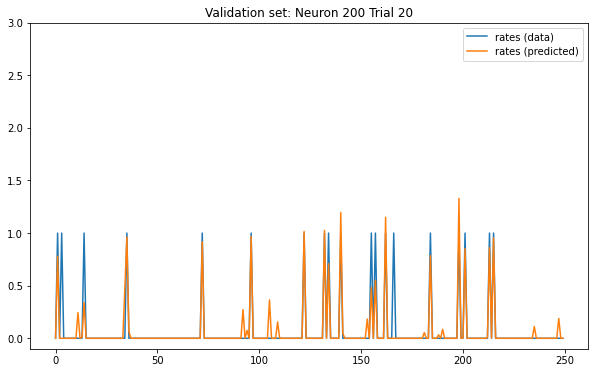

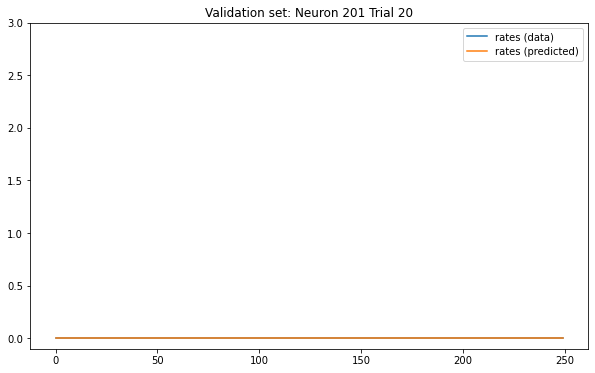

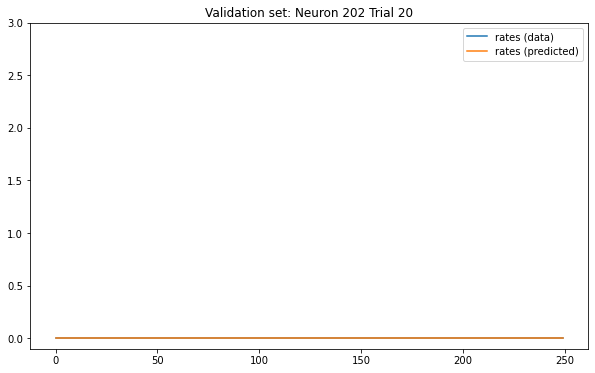

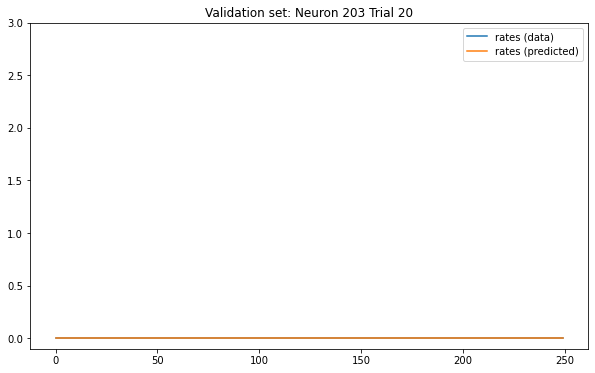

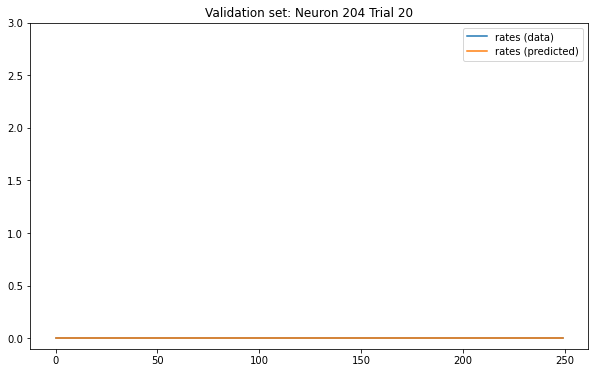

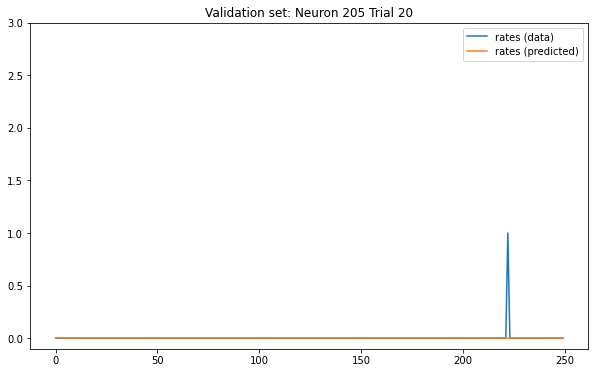

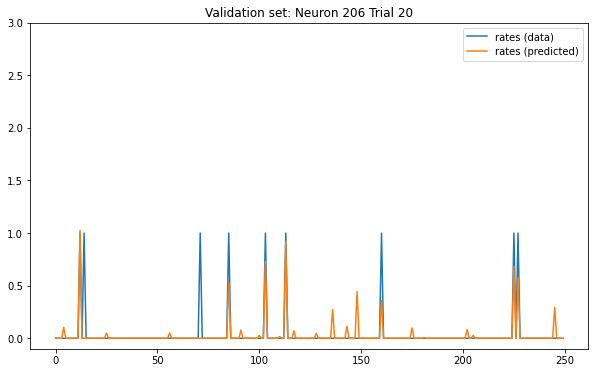

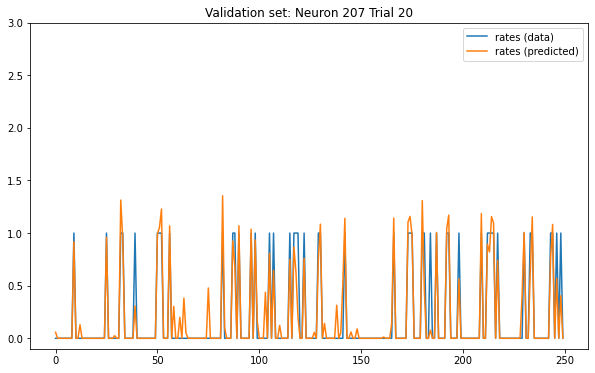

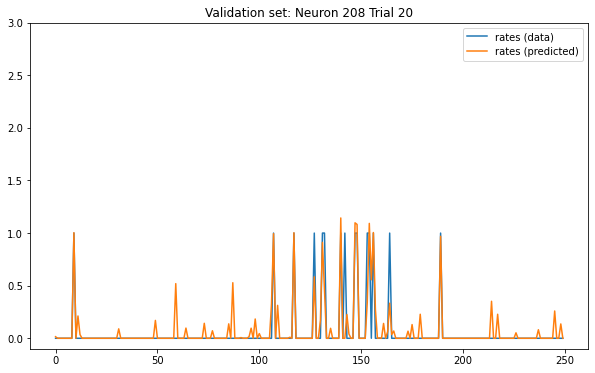

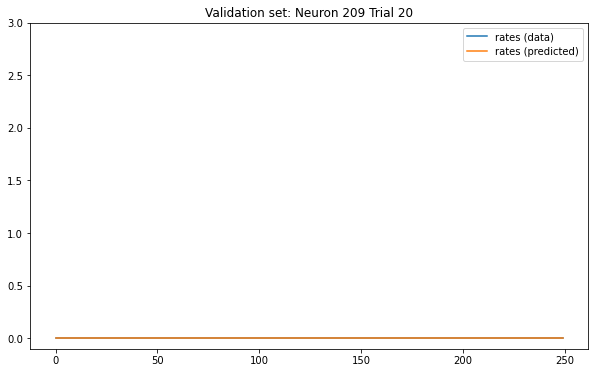

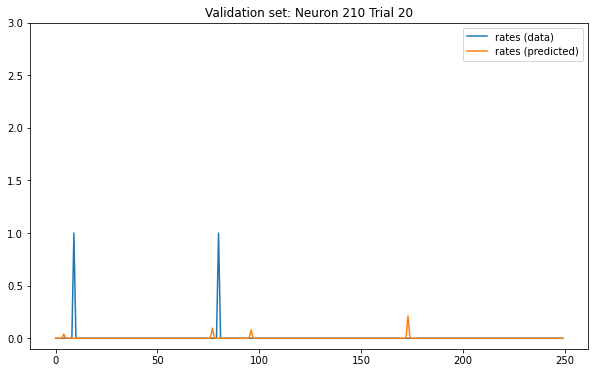

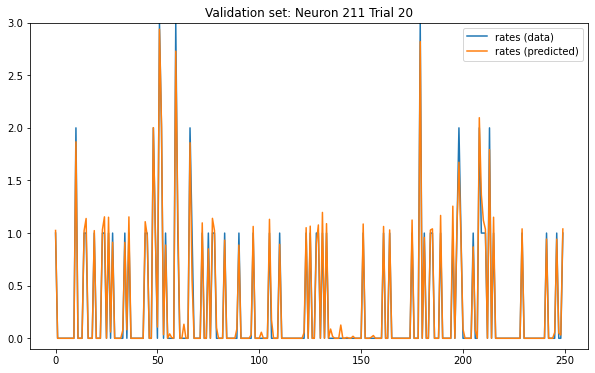

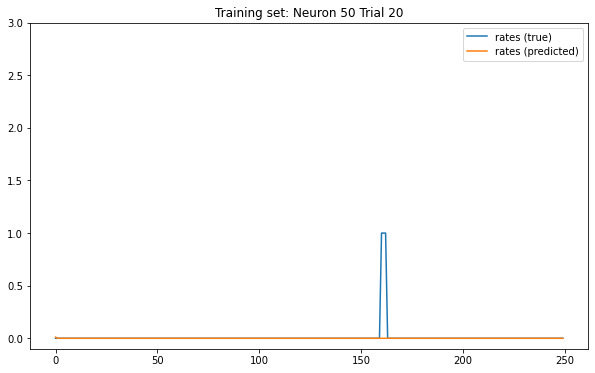

In [15]:
# visualize the performance of the rnn model
netinput=valData
prd=net(netinput)
rpred = prd.detach().cpu().numpy()
# nn_num = 30
ntrial = 20

for nn_num in range(valData.shape[-1]):
    # Plot for Test Data
    plt.figure(figsize=(10, 6))
    plt.plot(valData[:, ntrial, nn_num], label='rates (data)')
    plt.plot(rpred[:,ntrial, nn_num], label='rates (predicted)')
    plt.legend()
    plt.title(f'Validation set: Neuron {nn_num+200} Trial {ntrial}')
    plt.ylim((-0.1, 3))
    plt.show()

    if nn_num > 10:
        break

# Plot for Training Data
netinput=trainingData
prd=net(netinput)  
rpred = prd.detach().cpu().numpy()
nn_num = 50
ntrial = 20
plt.figure(figsize=(10, 6))
#plt.plot(fake_spk_rates[:,ntrial, nn_num], label='rates (true)')
plt.plot( trainingData[:, ntrial, nn_num], label='spikes')
plt.plot(rpred[:,ntrial, nn_num], label='rates (predicted)')

plt.legend(['rates (true)', 'rates (predicted)', 'spikes'])
plt.title(f'Training set: Neuron {nn_num} Trial {ntrial}')
plt.ylim((-0.1, 3))
plt.show()

In [16]:
## next: try the model with the real data

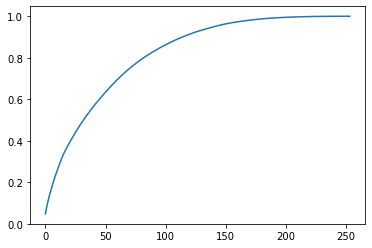

In [17]:
from sklearn.decomposition import PCA
pca = PCA().fit(trainingData.reshape(-1, trainingData.shape[-1]))
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [18]:
np.concatenate([np.arange(trainingData.shape[-1]).reshape(-1,1), pca.explained_variance_ratio_.cumsum().reshape(-1,1)], -1)

array([[0.00000000e+00, 4.72064559e-02],
       [1.00000000e+00, 7.81473136e-02],
       [2.00000000e+00, 1.05340445e-01],
       [3.00000000e+00, 1.28754833e-01],
       [4.00000000e+00, 1.50390497e-01],
       [5.00000000e+00, 1.70824396e-01],
       [6.00000000e+00, 1.90053506e-01],
       [7.00000000e+00, 2.08716199e-01],
       [8.00000000e+00, 2.26975811e-01],
       [9.00000000e+00, 2.43982213e-01],
       [1.00000000e+01, 2.60728845e-01],
       [1.10000000e+01, 2.76368287e-01],
       [1.20000000e+01, 2.91563063e-01],
       [1.30000000e+01, 3.06698483e-01],
       [1.40000000e+01, 3.21466393e-01],
       [1.50000000e+01, 3.35079891e-01],
       [1.60000000e+01, 3.46997768e-01],
       [1.70000000e+01, 3.58706181e-01],
       [1.80000000e+01, 3.69845906e-01],
       [1.90000000e+01, 3.80539057e-01],
       [2.00000000e+01, 3.90965382e-01],
       [2.10000000e+01, 4.01055589e-01],
       [2.20000000e+01, 4.11046864e-01],
       [2.30000000e+01, 4.20877944e-01],
       [2.400000

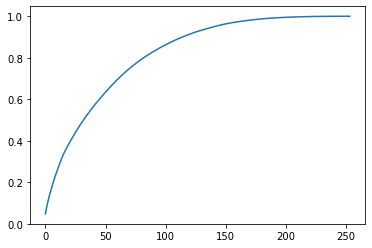

In [19]:
from sklearn.decomposition import PCA
pca = PCA().fit(trainingData.reshape(-1, trainingData.shape[-1]))
plt.plot(np.cumsum(pca.explained_variance_ratio_))


In [20]:
np.concatenate([np.arange(trainingData.shape[-1]).reshape(-1,1), pca.explained_variance_ratio_.cumsum().reshape(-1,1)], -1)

array([[0.00000000e+00, 4.72064559e-02],
       [1.00000000e+00, 7.81473136e-02],
       [2.00000000e+00, 1.05340445e-01],
       [3.00000000e+00, 1.28754833e-01],
       [4.00000000e+00, 1.50390497e-01],
       [5.00000000e+00, 1.70824396e-01],
       [6.00000000e+00, 1.90053506e-01],
       [7.00000000e+00, 2.08716199e-01],
       [8.00000000e+00, 2.26975811e-01],
       [9.00000000e+00, 2.43982213e-01],
       [1.00000000e+01, 2.60728845e-01],
       [1.10000000e+01, 2.76368287e-01],
       [1.20000000e+01, 2.91563063e-01],
       [1.30000000e+01, 3.06698483e-01],
       [1.40000000e+01, 3.21466393e-01],
       [1.50000000e+01, 3.35079891e-01],
       [1.60000000e+01, 3.46997768e-01],
       [1.70000000e+01, 3.58706181e-01],
       [1.80000000e+01, 3.69845906e-01],
       [1.90000000e+01, 3.80539057e-01],
       [2.00000000e+01, 3.90965382e-01],
       [2.10000000e+01, 4.01055589e-01],
       [2.20000000e+01, 4.11046864e-01],
       [2.30000000e+01, 4.20877944e-01],
       [2.400000

In [21]:
n_componenents = 50
testPCA = pca.transform(valData.reshape(-1, valData.shape[-1]))
testReconstructed = pca.inverse_transform(testPCA)[...,:n_componenents].reshape(valData.size(0), valData.size(1), -1)

# plt.plot(testReconstructed[ntrial,nn_num])


In [22]:
# nn.MSELoss(torch.tensor(testReconstructed), valData)

In [23]:
# # prepare for training

# # file = open("Cori_MOs.pkl",'rb')
# file = open("Cori_Post.pkl",'rb')
# spk = pickle.load(file)

# NT=spk.shape[0]
# ntrials=spk.shape[1]
# NN=spk.shape[2]
# ncomp=10

# trainingData = torch.from_numpy(spk[:, :ntrials*4//5, :]).to(device).float()
# valData = torch.from_numpy(spk[:, ntrials*4//5:, :]).to(device).float()
